# Overview

This notebook predicts the possibility of a customer defaulting his/her loan


# Set parameters / environments


In [13]:
data_dir = "/Users/daddy2/01-prj/kaggle-home-credit-default-risk/2018/input/home-credit-default-risk" 
# "/kaggle/input/kaggle-home-credit-default-risk"
train_csv_path = data_dir + "/application_train.csv"
test_csv_path = data_dir + "/application_test.csv"


LR_SEED = 1
SPLIT_SEED = 1
CSV_INDEX_COLUMN = "SK_ID_CURR"
LABEL_COL = "TARGET"
TRAIN_SET_RATIO = 0.99
SEPARATOR = ("-" * 100) + "\n"

# test files in the parameter exists
import os

assert os.path.exists(data_dir), print(f"can't find {data_dir}")

for f in [train_csv_path, test_csv_path]:
    assert os.path.exists(os.path.join(data_dir, f)), logging.error(f"can't find {f}")

## Set logging environment


In [14]:
import logging

logging.basicConfig(level=logging.DEBUG)

# Suppress warning
for package in ["numba", "matplotlib"]:
    logging.getLogger(package).setLevel(logging.WARNING)

# Speed up using cuDF (Optional)

Reference https://rapids.ai/cudf-pandas/


In [15]:
if 0:
    %load_ext cudf.pandas
    if 0: # install package quietly
        !pip install --quiet -r requirements.txt

In [16]:
import pandas as pd
import sklearn

df_train = pd.read_csv(train_csv_path)
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Replace dataframe index


In [17]:
# Set CSV_INDEX_COLUMN as index

if df_train.index.name is not CSV_INDEX_COLUMN:
    assert CSV_INDEX_COLUMN in list(df_train.columns), print(
        f"{CSV_INDEX_COLUMN} not a column name"
    )
    # check any duplicated index
    assert not df_train[CSV_INDEX_COLUMN].duplicated().any(), print(
        "Duplicated index SK_ID_CURR"
    )
    df_train.set_index(CSV_INDEX_COLUMN, inplace=True)

In [19]:
if 0:  # 1 if use full dataset, 0 if use subset

    from sklearn.model_selection import train_test_split

    df = df_train

    features_col = list(df.columns)
    features_col.remove(LABEL_COL)

    X_train, X_test, y_train, y_test = train_test_split(
        df[features_col],
        df[LABEL_COL],
        test_size=1 - TRAIN_SET_RATIO,
        random_state=SPLIT_SEED,
        stratify=df[LABEL_COL],
    )

    for k, v in {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }.items():
        # logging.info(f"len {len(n)}")
        logging.info("Dataframe for %s with shape %s" % (k, str(v.shape)))
        display(v.head())
        logging.info(SEPARATOR)

    pd.concat([X_test, y_test], axis=1).to_csv("./dummy_X_test_y_test.csv", index=True)
else:
    df = pd.read_csv("./dummy_X_test_y_test.csv")
    df.set_index("SK_ID_CURR", inplace=True)
    # display(df.head())
    X_test = df[list(df.columns)[:-1]]
    y_test = df[list(df.columns)[-1]]

    logging.info("Feature")
    display(X_test.head())
    logging.info("Target")
    display(y_test.head())

INFO:root:Dataframe for X_train with shape (304435, 120)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
447117,Cash loans,F,N,Y,0,135000.0,337761.0,17374.5,256500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
446425,Cash loans,M,N,Y,1,135000.0,521280.0,31500.0,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
295394,Cash loans,F,N,Y,0,90000.0,808650.0,23643.0,675000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
390886,Cash loans,M,N,Y,1,90000.0,264888.0,28656.0,234000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
345373,Cash loans,M,N,Y,0,99000.0,50940.0,5346.0,45000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


INFO:root:----------------------------------------------------------------------------------------------------

INFO:root:Dataframe for X_test with shape (3076, 120)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
281356,Cash loans,M,N,N,0,81000.0,247500.0,11538.0,247500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
142798,Cash loans,F,N,N,0,90000.0,90000.0,3523.5,90000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,9.0,0.0,5.0
255780,Cash loans,M,N,N,1,112500.0,495000.0,18184.5,495000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,4.0,0.0,1.0
139435,Cash loans,F,N,N,0,180000.0,1190340.0,66595.5,1125000.0,Family,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
392421,Cash loans,M,Y,Y,0,90000.0,288873.0,19435.5,238500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


INFO:root:----------------------------------------------------------------------------------------------------

INFO:root:Dataframe for y_train with shape (304435,)


SK_ID_CURR
447117    0
446425    1
295394    0
390886    0
345373    0
Name: TARGET, dtype: int64

INFO:root:----------------------------------------------------------------------------------------------------

INFO:root:Dataframe for y_test with shape (3076,)


SK_ID_CURR
281356    0
142798    0
255780    0
139435    0
392421    1
Name: TARGET, dtype: int64

INFO:root:----------------------------------------------------------------------------------------------------



In [ ]:
if 0:  # show distribution of missing value
    import missingno

    # fig = missingno.matrix(df)
    # fig_copy = fig.get_figure()
    # fig_copy.savefig("missingno1.png", bbox_inches="tight")

# Visualize missing values

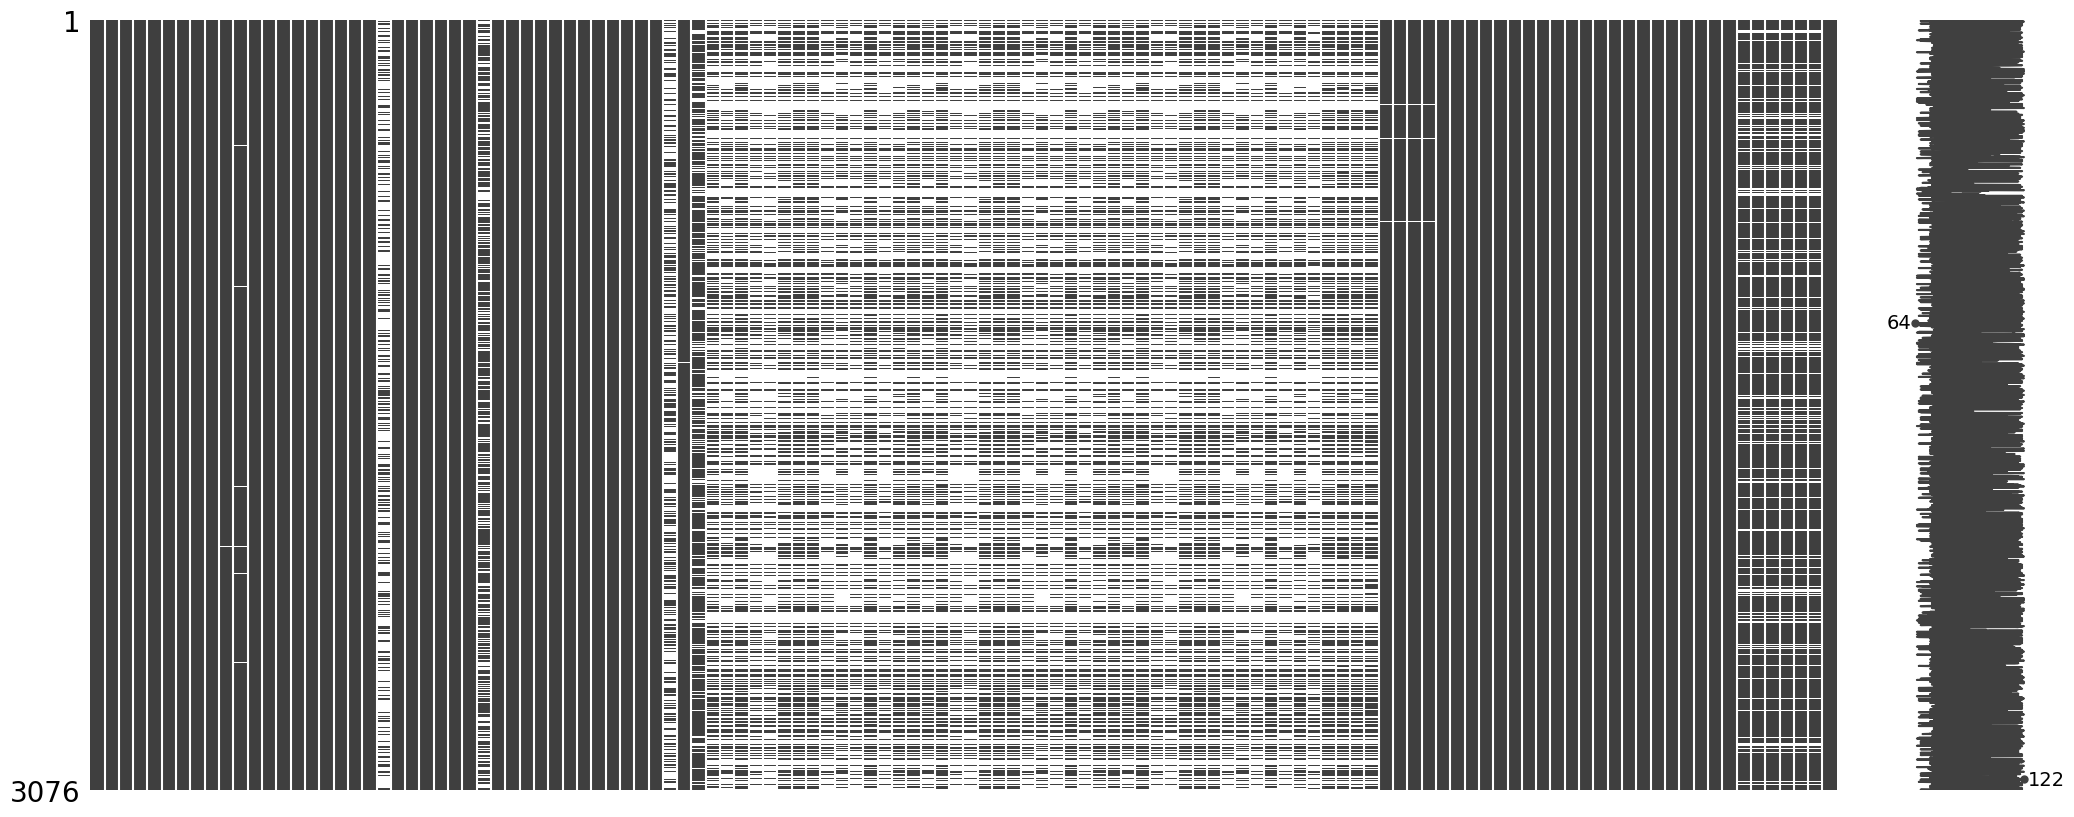


In [ ]:
# correlation = df.corr()["TARGET"]

In [ ]:
if 0:  # fillna
    df_cat.fillna("-1", inplace=True)
    display(df_cat.head())

In [ ]:
if 0:  # cat2num
    unique = {}
    max_ = 0
    cat_col = list(df_cat.columns)
    cat_col.remove("SK_ID_CURR")

    for c in list(df_cat.columns):
        cat = list(df_cat[c].unique())
        # print(c, cat)
        try:
            cat.sort()
        except:
            print(f"## cant sort {c} {cat}")

        unique[c] = cat
        max_ = max(max_, len(cat))

    # unique

    for c in df_cat.columns:
        df_cat[c] = df_cat[c].apply(lambda x: unique[c].index(x) if x != "-1" else x)

    df_cat.head()

In [ ]:
if 0:  # merge
    df_train.set_index("SK_ID_CURR").update(df_cat.set_index("SK_ID_CURR"))
    df_train.head()

In [ ]:
if 0:  # wrong replacemment without considering index
    for c in df_cat.columns:
        df_train[c] = df_cat[c]

    df_train[cat_col].head()

# Pre-processing

Function to preprocess train and test data before fitting the output to model

input: raw csv data
output: imputed, normalized data

## Encode categorical data

There's 16 categorical data to be encoded:

<pre>
'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
<pre>


Nan value is encoded to "??"


## Imputation

Ref https://www.kdnuggets.com/2022/07/scikitlearn-imputer.html


COMMONAREA_MODE             0.702211
COMMONAREA_AVG              0.702211
COMMONAREA_MEDI             0.702211
NONLIVINGAPARTMENTS_MEDI    0.701886
NONLIVINGAPARTMENTS_AVG     0.701886
dtype: float64

INFO:root:Percentage of missing values


<Axes: >

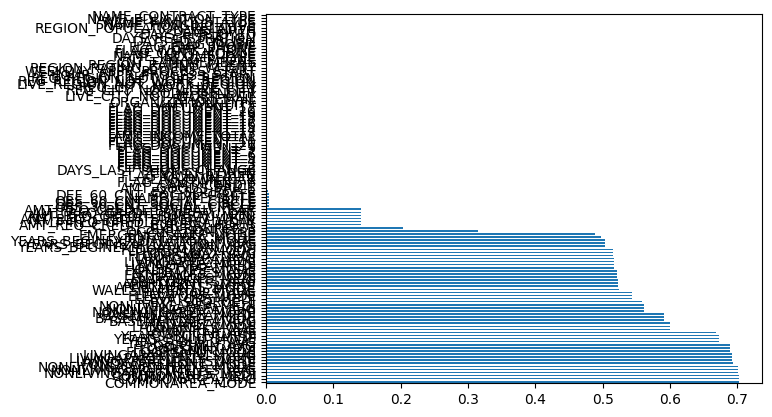

In [20]:
if 1:  # plot percentage of missing value
    percent_of_na = X_test.isna().sum(axis=0).sort_values(ascending=False) / len(X_test)
    display(percent_of_na.head())
    logging.info("Percentage of missing values")
    display(percent_of_na.plot(kind="barh"))

In [21]:
from sklearn.impute import SimpleImputer

# Create sample DataFrame
data = {"Age": [25, 35, np.nan], "Income": [50000, np.nan, 70000]}
df = pd.DataFrame(data)

columns_isna_any_before = list(df.isna().any().index)

columns_isna_indicator = [col + "_is_imputed" for col in columns_isna_any_before]

# Impute with indicator columns
imputer = SimpleImputer(strategy="mean")
imputed_df = pd.DataFrame(
    imputer.fit_transform(df[columns_isna_any_before]), columns=columns_isna_any_before
)

df[columns_isna_indicator] = df[columns_isna_any_before].isna()

df_conca = pd.concat([imputed_df, df[columns_isna_indicator]], axis=1)
display(df_conca)

columns = list(df_conca.columns)
columns.sort()
display(df_conca[columns])


# # Print column names to see the appended suffixes
# print(imputed_df.columns)

# Check for perfect negative correlations
print(df_conca.corr())

NameError: name 'np' is not defined

In [22]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np

# Create a sample DataFrame with missing values
if 0:
    data = {"A": [1, 2, None, 4, None], "B": [None, 2, 3, None, 5]}
else:
    data = {"A": [1, 2, None, 4, np.nan], "B": [None, 2, 3, np.nan, 5]}
df = pd.DataFrame(data)

# Initialize SimpleImputer with strategy 'most_frequent'
imputer = SimpleImputer(strategy="most_frequent")

display(df)
# Fit and transform the imputer to the DataFrame
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Output the imputed DataFrame
display(df_imputed)

,A,B
0,1.0,NaN
1,2.0,2.0
2,NaN,3.0
3,4.0,NaN
4,NaN,5.0


,A,B
0,1.0,2.0
1,2.0,2.0
2,1.0,3.0
3,4.0,2.0
4,1.0,5.0


In [23]:
if 1:
    # %%timeit
    from sklearn.impute import SimpleImputer
    import pandas as pd
    import numpy as np

    def try_impute(df):
        # # Define the imputer
        # imputer = SimpleImputer(strategy="most_frequent")

        # # Impute missing values in both columns
        # df_imputed = pd.DataFrame(imputer.fit_transform(df))

        # # Set column names (optional, since they are preserved by default)
        # df_imputed.columns = df.columns
        # # display(df_imputed)

        # assert not (df_imputed.isna().any().sum()), print("found isna")

        # Initialize SimpleImputer with strategy 'most_frequent'
        imputer = SimpleImputer(strategy="most_frequent", add_indicator=True)

        display(df)
        # Fit and transform the imputer to the DataFrame
        df_imputed = pd.DataFrame(
            imputer.fit_transform(df),
            #   columns=df.columns
        )

        return df_imputed

    np.random.seed(1)

    # Sample data
    if 0:
        data = {
            "col1": ["A", "C", "C", np.nan, np.nan, np.nan],
            "col2": ["X", "Y", np.nan, "X", "Y", np.nan],
        }
    else:
        data = {"A": [1, 1, None, 4, np.nan], "B": [None, "A", "B", np.nan, 5]}
    df = pd.DataFrame(data)

    # df1 = df[object_cols][:5]
    df1 = df
    object_cols = set(df.select_dtypes("object").columns)
    numerical_cols = list(set(df.columns) - object_cols)
    logging.info(f"numerical_cols {numerical_cols}")
    logging.info("before")
    display(df1)

df_imputed = try_impute(df1[numerical_cols])
logging.info("after")
display(df_imputed)

# print(df_imputed)

INFO:root:numerical_cols ['A']
INFO:root:before


,A,B
0,1.0,None
1,1.0,A
2,NaN,B
3,4.0,NaN
4,NaN,5


,A
0,1.0
1,1.0
2,NaN
3,4.0
4,NaN


INFO:root:after


,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,1.0
3,4.0,0.0
4,1.0,1.0


In [ ]:
from sklearn.preprocessing import LabelEncoder


def label_encoder(df: pd.DataFrame) -> pd.DataFrame:

    # Create a label encoder object
    le = LabelEncoder()
    label_encoded = []

    # Iterate through the columns
    for col in list(df.select_dtypes("object").columns):
        if len(df[col].unique()) <= 2:
            unique_values = list(df[col].unique())
            # Train on the training data
            le.fit(df[col])

            # Transform both training and testing data
            # ?? how to know which cat converted to which num
            df[col] = le.transform(df[col])

            logging.info(
                f"Encpded {unique_values} to {list(df[col].unique())} in {col}"
            )

            # Keep track of label encoded columns
            label_encoded.append(col)

    return label_encoded

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer as Imputer
import numpy as np
import missingno


# ?? what if most frequent values is NaN, mean no replacement?
def preprocessing(
    df: pd.DataFrame, is_describe=False, strategy="most_frequent", is_dropna=False
) -> pd.DataFrame:

    object_cols = set(df.select_dtypes("object").columns)
    numerical_cols = list(set(df.columns) - object_cols)

    # logging.info(f"object_cols {object_cols}")
    # display(missingno.matrix(df[object_cols]))

    # logging.info(f"numerical_cols {numerical_cols}")
    # display(missingno.matrix(df[numerical_cols]))

    # # scale within each feature
    # display(df[numerical_cols].head())

    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler.fit(df[numerical_cols])
    # scaler_output_numpy = scaler.transform(df[numerical_cols])

    # df[numerical_cols] = pd.DataFrame(
    #     scaler_output_numpy, columns=numerical_cols, index=df.index.to_list()
    # )
    # display(df[numerical_cols].head)

    # df_copied = df.copy()
    # logging.debug()
    # Imputation of missing values using strategy given

    isna_by_columns = df.isna().any()
    columns_with_missing_value = list(isna_by_columns.index[isna_by_columns])

    isna_object_cols = list(set(columns_with_missing_value) & set(object_cols))

    imputer = Imputer(strategy="most_frequent")
    # Fit on the training data
    df1 = df[isna_object_cols].copy()
    imputer.fit(df1)
    imputer_output_numpy = imputer.transform(df1)
    # missingno.matrix(df[isna_object_cols])
    display(df1.isna().sum().sort_values(ascending=False)[:5])

    # print("imputer_output_numpy.isnan()", (np.isnan(imputer_output_numpy).sum()))
    df_imputed = pd.DataFrame(
        imputer_output_numpy,
        columns=isna_object_cols,
        index=df.index.to_list(),
    )
    display(df_imputed.isna().sum().sort_values(ascending=False)[:5])

    return df


logging.info("After proprocessing")
tmp = X_test.copy()
df_processed = preprocessing(tmp)

In [ ]:
# df_imputed.columns = isna_object_cols
# df[isna_object_cols] = df_imputed
# missingno.matrix(df[isna_object_cols])

# assert df[isna_object_cols].isna().any().sum(), print("isna_object_cols")

# isna_numerical_cols = list(set(columns_with_missing_value) & set(numerical_cols))
# imputer = Imputer(strategy="mean")
# # Fit on the training data
# imputer.fit(df[isna_numerical_cols])
# imputer_output_numpy = imputer.transform(df[isna_numerical_cols])
# df[isna_numerical_cols] = pd.DataFrame(
#     imputer_output_numpy,
#     columns=isna_numerical_cols,
#     index=df.index.to_list(),
# )
# assert df[isna_numerical_cols].isna().any().sum(), print("isna_numerical_cols")

# assert set(columns_with_missing_value) == (
#     set(isna_numerical_cols) | set(isna_object_cols)
# ), print(
#     [
#         len(c)
#         for c in [columns_with_missing_value, isna_numerical_cols, isna_object_cols]
#     ]
# )

# if sum(df.isna().any()):
#     logging.info(f"Before dropna shape {df.shape}")
#     df.dropna(inplace=True)
#     logging.info(f"after dropna shape {df.shape}")

# display(df[numerical_cols].head())

# if is_describe:
#     display(df)
#     display(processed)

In [ ]:
df = X_test.copy()

object_cols = set(df.select_dtypes("object").columns)
numerical_cols = list(set(df.columns) - object_cols)

isna_by_columns = df.isna().any()
columns_with_missing_value = list(isna_by_columns.index[isna_by_columns])

isna_numerical_col = list(set(columns_with_missing_value) & set(numerical_cols))
isna_object_cols = list(set(columns_with_missing_value) & set(object_cols))

In [ ]:
X_test.dtypes.value_counts().plot.pie()

In [ ]:
binary_categorical_columns = [
    col
    for col in X_test.select_dtypes("object").columns
    if len(X_test[col].unique()) <= 2
]

binary_categorical_columns.sort()
logging.info("Before label encoding")
display(X_test[binary_categorical_columns].head())

label_encoded_cols = label_encoder(X_test)

label_encoded_cols.sort()
logging.info("After label encoding")
display(X_test[label_encoded_cols].head())

# print(f"%d columns were label encoded:\n{label_encoded_cols}" % len(label_encoded_cols))

# Imputing and scaling


In [ ]:
search_string = "Unaccompanied"
cols = []
for c in X_test.select_dtypes("object").columns:
    X_test[c].apply(lambda x: (search_string in x) if (x != None) else x).any()
    cols.append(c)

print("match", cols)

In [ ]:
logging.info("After proprocessing")
_ = preprocessing(X_test)
# index = series[series == True].index
# print(f"{len(index)} columns with nan values, eg. {index.head()}")
# display(X_test.head())

## One-hot encoding of non-binary categorical variables

Using 1-hot encoding to overcome rank and an order for label encoding


In [ ]:
cat_cols = list(X_test.select_dtypes("object"))
cat_cols.sort()
logging.info(f"There are {len(cat_cols)} categorical features, eg. {cat_cols[:5]}")

X_test[cat_cols].head()

In [ ]:
non_cat_cols = list(set(X_test.columns) - set(cat_cols))
non_cat_cols.sort()
logging.info(f"There are {len(non_cat_cols)} non categorical features")
display(X_test[non_cat_cols].head())

In [ ]:
ori_shape = X_test.shape
logging.info(f"Before 1-hot encoding, shape {ori_shape} ", end="")
X_test = pd.get_dummies(X_test)
logging.info(f"After 1-hot encoding shape {X_test.shape}")
assert not len(X_test.select_dtypes("object").columns), print(
    f"Remaining categorical features {(X_test.select_dtypes('object').columns)}"
)

In [ ]:
# print("Before proprocessing")
# series = X_test.isna().any()
# index = series[series == True].index
# print(f"{len(index)} columns with nan values, eg. {index}")
# display(X_test.head())

In [ ]:
if 0:  # troubleshoot nan after imputation
    X_test["AMT_GOODS_PRICE"][X_test["AMT_GOODS_PRICE"].isna()].head()

    series = X_test.isna().any()
    index = series[series == True].index
    print(f"Columns with nan values {index}")

# Train model using logistic regression

Use logistic regression because this is a binary classification problem (default or not default)


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# temporary solution to drop columns with missing values
df_join = pd.concat([X_test, y_test], axis=1)
df_join.shape

df_join.dropna(inplace=True)

In [ ]:
cols = list(df_join.columns)
lr_fit = LogisticRegression(random_state=LR_SEED).fit(
    X=df_join[cols[:-1]], y=df_join[cols[-1]]
)
y_predict = lr_fit.predict(df_join[cols[:-1]])

# Reference

https://www.kaggle.com/code/wschong/home-credit-default-risk-lr-rf-lgbm/edit


In [ ]:
# from sklearn.model_selection.